<a href="https://colab.research.google.com/github/sumugowda/Image_caption_genrator/blob/main/ImagecaptionGenlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image caption generator learning



In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical

In [ ]:
BASE_Dir = '/content/drive/MyDrive/Imagecaption'
worDir = '/content/drive/MyDrive/workdir'

## Extract Image Features




In [ ]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 19s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
features = {}
directory = os.path.join(BASE_Dir, 'Images')
for img_name in tqdm(os.listdir(directory)):
  img_path = directory + '/' + img_name
  image = load_img(img_path, target_size=(224,224))
  image = img_to_array(image)

  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)

  feature = model.predict(image, verbose=0)

  image_id = img_name.split('.')[0]
  features[image_id] = feature

  0%|          | 0/8151 [00:00<?, ?it/s]

In [ ]:
# store features
pickle.dump(features, open(os.path.join(worDir, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(worDir, 'features.pkl'), 'rb') as f:
  features = pickle.load(f)

## Load captions

In [ ]:
with open(os.path.join(BASE_Dir, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

### Mapping image and captions


In [ ]:
mapping ={}

# line processing
for line in tqdm(captions_doc.split('\n')):
  tokens = line.split(',')
  if len(line)<2:
    continue
  image_id, caption = tokens[0], tokens[1:]

  image_id = image_id.split('.')[0]

  caption = ' '.join(caption)

  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)




  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

## Text Preprocessing

In [ ]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):

      caption = captions[i]

      caption = caption.lower()

      caption = caption.replace('[A-Za-z]', '')

      caption = caption.replace('\s+', ' ')

      caption = '<start> ' + " ".join([word for word in caption.split() if len(word)>1]) + ' <end>'

      captions[i] = caption


In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)

In [ ]:
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [ ]:
tokenzier = Tokenizer()
tokenzier.fit_on_texts(all_captions)
vocab_size = len(tokenzier.word_index) + 1
vocab_size

8483

In [ ]:
max_len =  max(len(caption.split()) for caption in all_captions)
max_len

35

## Train and test dataset

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# Making batches

def datagenerator(data_keys, mapping, features, tokenizer, max_len, vocab_size, batch_size):
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]

      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]

          # pad input seq
          in_seq = pad_sequences([in_seq], maxlen=max_len)[0]

          # encode outseq

          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2], y
        X1, X2, y = list(), list(), list()
        n = 0

## Model Building

In [ ]:
!pip install pydot
# Import necessary libraries
from keras.utils import plot_model

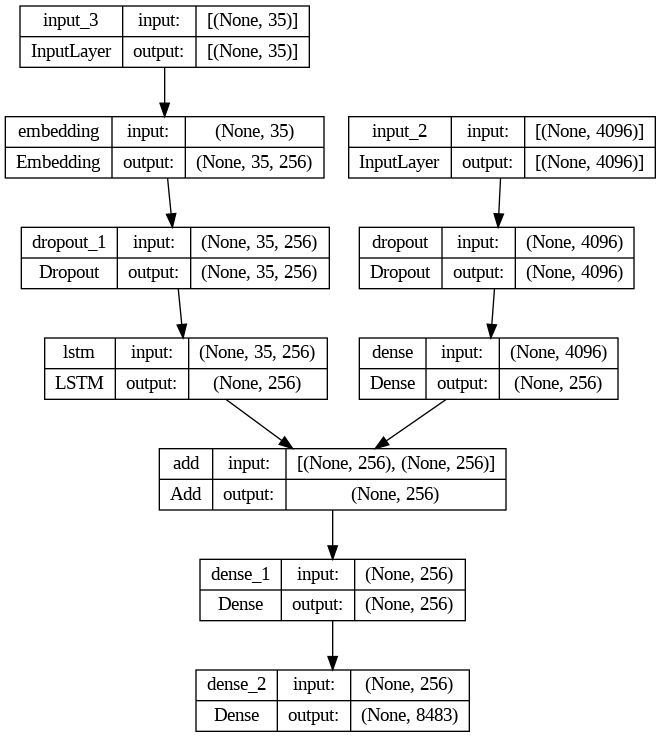

In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#plot model

plot_model(model, show_shapes=True)

In [ ]:
# Model training

epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
  generator = datagenerator(train, mapping, features, tokenzier, max_len, vocab_size, batch_size)
  #fit for 1 epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 [==============================] - 1138s 10s/step - loss: 2.4819


In [ ]:
model.save(worDir + '/capmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generate Captions for the image

In [26]:
def idx_to_word(integer, tokenzier):
  for word, index in tokenzier.word_index.items():
    if index == integer:
      return word

  return none

In [27]:
#generate caption for an image
def predict_caption(model,image,tokenzier,max_len):
  in_text = '<start>'

  # iterate over the max length of seq

  for i in range(max_len):
    sequence = tokenzier.texts_to_sequences([in_text])[0]

    #pad the sequences

    sequence = pad_sequences([sequence], maxlen=max_len)

    # predict next word
    yhat = model.predict([image, sequence], verbose=0)

    # get index with max probability

    yhat = np.argmax(yhat)

    # convert index to word

    word = idx_to_word(yhat, tokenzier)

    # stop if word not found
    if word is None:
      break

    # append word as input for generating next word

    in_text += ' ' + word

    # stop if we reach end tag

    if word == '<end>':
      break

  return in_text


In [29]:
# Validate with test data
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):

  captions = mapping[key]

  y_pred = predict_caption(model, features[key], tokenzier, max_len)

  actual_captions = [mapping[key][i].split() for i in range(len(mapping[key]))]

  actual.append(actual_captions)
  predicted.append(y_pred.split())

  # calculate Bleu score

print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Visualize results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  # image_name = "1000268201_693b08cb0e.jpg"
  img_path = os.path.join(BASE_Dir, 'Images', image_name)
  image = Image.open(img_path)
  captions = mapping[image_name]
  print('---------------------Actual------------------')
  for caption in captions:
    print(caption)
  print('---------------------Predicted-----------------')
  print(predict_caption(model, features[image_name], tokenzier, max_len))
  plt.imshow(image)

In [ ]:
generate_caption('1000268201_693b08cb0e.jpg')